# Code for Jupyter Notebook demo (July-2018): 

## Building a deep learning models for fraud detection 

## References: 

- Preconfigured Virtual Machines: https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/ 

- Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

- Blog Post by Venelin Valkov: https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

- Deep Learning Book by Ian Goodfellow, Yoshua Bengio, Aaron Courville: http://www.deeplearningbook.org/ 

## Environment setup

In [1]:
# Import necessary components
import os
import keras
import shutil
import json

Using TensorFlow backend.


In [2]:
import re
import pandas as pd
import numpy as np
import datetime

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from math import ceil

In [3]:
import pickle
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [12]:
import os
cwd = os.getcwd()
cwd

'C:\\dsvm\\notebooks'

In [5]:
import matplotlib as plt 

In [6]:
%matplotlib inline

In [7]:
import glob
import os

from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

Enter the credentials to access the data from the cloud and then download the file for analysis.

In [8]:
# Azure blob credentials to read data
storage_account = 'jayastratalondon'
storage_key = 'OZr4vx9xLlNTOWlC+u/Yw/hb4N1v4BSB0ITFUz7zyvKsA0lEV+ohxQ5x3RIaUK3f+TMnRxvn/lpDzWSr7YJyww=='

input_container = 'stratalondon'
output_container = 'modeldeploy'

az_blob_service = BlockBlobService(account_name=storage_account, account_key=storage_key)

In [9]:
blob_service = BlockBlobService(account_name=storage_account, account_key=storage_key)
input_container_folder = 'stratalondon/'
generator = blob_service.list_blobs(input_container_folder)
for blob in generator:
    if ("creditcard" in blob.name):
        print(blob.name)
        fname=blob.name

creditcard.csv


In [16]:
aml_dir = cwd
my_service = BlockBlobService(account_name=storage_account, account_key=storage_key)
my_service.get_blob_to_path('stratalondon', fname, 'C://dsvm//notebooks/creditcard.csv')

## Import the Credit card data set

In [17]:
# Check the path
aml_dir

'C:\\dsvm\\notebooks'

In [19]:
# Ingest the dataset
cc = pd.read_csv('C://dsvm//notebooks/creditcard.csv')

After data ingestion from Blob, check to see the various columns and number of rows/columns of the dataset.

In [20]:
# Check sample data
cc.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [21]:
# Check the number of rows/columns
cc.shape

(284807, 31)

Now that the data is properly imported, check the descriptive statistics of the columns in the dataset.

In [22]:
# Check data statistics
print(cc.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271e+00  1.23709

Here we visualize and access the distribution of the variable 'Class'. This is the variable which indicates whether a transaction was fraud/normal. 

In [23]:
from matplotlib import pyplot as plt 

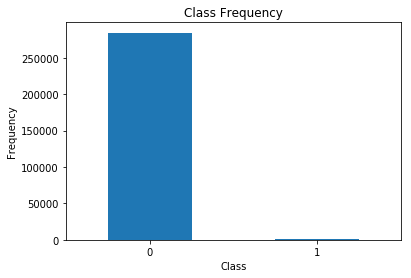

In [24]:
# Variable class is used for the classification of entries as fraud/non-fraud, check the distribution of the variable
class_freq = pd.value_counts(cc['Class'], sort = True)
class_freq.plot(kind = 'bar', rot=0)
plt.title("Class Frequency")
plt.xlabel("Class")
plt.ylabel("Frequency");

In [25]:
# Count of Fraud/normal transactions
fraud = cc[cc.Class == 1]
normal = cc[cc.Class == 0]
print("Number of Fraud transactions:")
print(fraud.shape)
print("Number of Non-Fraud transactions:")
print(normal.shape)
print("% of Fraud transactions:")
prop = (len(fraud)/(len(fraud)+len(normal)))*100
print(prop)

Number of Fraud transactions:
(492, 31)
Number of Non-Fraud transactions:
(284315, 31)
% of Fraud transactions:
0.1727485630620034


Check to see how the fraud/normal transactions vary in terms of variable 'Amount'.

In [26]:
# Check Fraud data statistics for variable = 'Amount'
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [27]:
# Compare Fraud data statistics with normal data for variable = 'Amount'
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Modeling 

First exclude the variable 'Time'. Since the spread of the variable 'Amount' is large, this variable is standardized. 

In [28]:
# Remove the column 'Time' and standardize the variable 'Amount'
from sklearn.preprocessing import StandardScaler
data = cc.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Next step is to split the data into train/test.

In [29]:
# Split the data into train/test and remove variable 'Class' and prepare for autoencoder
X_train, X_test = train_test_split(data, test_size=0.3, random_state=123)
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

print("X_train:")
print(X_train.shape)
print("X_test:")
print(X_test.shape)

X_train:
(199364, 29)
X_test:
(85443, 29)


In [30]:
X_test[1]

array([ 2.15574786, -0.99822258, -1.15897829, -0.99229813, -0.48459951,
       -0.30885748, -0.67707687, -0.19351731, -0.08302644,  0.70535673,
       -1.55210692, -0.41524791,  1.04034025, -0.53313654,  0.07619587,
        1.2201284 , -0.14748371, -1.22145703,  0.87802608,  0.12463626,
        0.17477517,  0.51900531,  0.00346   , -1.01796213, -0.00946463,
       -0.11843454, -0.00634987, -0.05337546, -0.12134039])

Define the framework for the autoencoder and then compile and fit using the training data.

In [31]:
# Define the encoded/decoder framework
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [32]:
# Compile and fit the autoencoder
nb_epoch = 5
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_test, X_test), verbose=1).history

Train on 199364 samples, validate on 85443 samples
Epoch 1/5
199364/199364 [==============================] - 23s - loss: 0.8557 - acc: 0.5983 - val_loss: 0.7907 - val_acc: 0.6420
Epoch 2/5
199364/199364 [==============================] - 21s - loss: 0.7908 - acc: 0.6507 - val_loss: 0.7714 - val_acc: 0.6580
Epoch 3/5
199364/199364 [==============================] - 21s - loss: 0.7787 - acc: 0.6675 - val_loss: 0.7651 - val_acc: 0.6731
Epoch 4/5
199364/199364 [==============================] - 21s - loss: 0.7731 - acc: 0.6738 - val_loss: 0.7598 - val_acc: 0.6735
Epoch 5/5
199364/199364 [==============================] - 21s - loss: 0.7693 - acc: 0.6767 - val_loss: 0.7584 - val_acc: 0.6770


In [33]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

In [34]:
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.751677,0.001873
std,3.772114,0.043233
min,0.036619,0.000000
25%,0.246241,0.000000
50%,0.401148,0.000000
75%,0.630296,0.000000
max,454.837997,1.000000


The model can be accessed based on various metrics: ROC curve, precision, recall based on the business requirement. 

In [35]:
# Metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

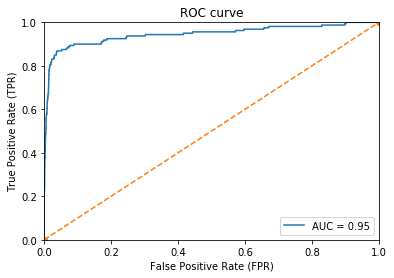

In [36]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'o--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show();

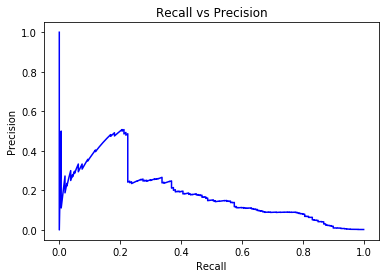

In [37]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Saving the model

In [38]:
autoencoder

In [43]:
# Save the model for operationalization: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
from keras.models import model_from_json
import os
import h5py
from sklearn import datasets 
 
# save model
# serialize model to JSON
model_json = autoencoder.to_json()
with open("C://dsvm//notebooks/autoencoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("C://dsvm//notebooks/autoencoder.h5")
print("Model saved")

Model saved


In [45]:
# load json and create model
json_file = open('C://dsvm//notebooks/autoencoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C://dsvm//notebooks/autoencoder.h5")
print("Model loaded")

Model loaded


In [46]:
score = loaded_model.predict(X_test)
print(score.shape)

(85443, 29)


In [47]:
score[1]

array([ 1.90868819,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.17799079,  0.24152863,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02735971,
        0.01728183,  0.        ,  0.        ,  0.        ], dtype=float32)

In [48]:
X_test[1]

array([ 2.15574786, -0.99822258, -1.15897829, -0.99229813, -0.48459951,
       -0.30885748, -0.67707687, -0.19351731, -0.08302644,  0.70535673,
       -1.55210692, -0.41524791,  1.04034025, -0.53313654,  0.07619587,
        1.2201284 , -0.14748371, -1.22145703,  0.87802608,  0.12463626,
        0.17477517,  0.51900531,  0.00346   , -1.01796213, -0.00946463,
       -0.11843454, -0.00634987, -0.05337546, -0.12134039])